# Prediction #

After a first check on the data, using ordinal regressions and linear regressions, we can add new variables we've seen can help with prediction and use them with more complex models such as tree based or mlp models.

In [1]:
import pandas as pd
import numpy as np
from sklearn import feature_selection
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error,roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression, PoissonRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
import pickle
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# we will see how this compares to betting odds auc



In [3]:
betting_data = test[['B365A', 'B365D', 'B365H']]


In [4]:
train.drop(['home_formation', 'away_fromation', 'Unnamed: 0'], axis=1, inplace=True)
test.drop(['home_formation', 'away_fromation', 'Unnamed: 0'], axis=1, inplace=True)


In [5]:
# cols_to_keep = ['home_score','away_score','home_team_name', 'away_team_name',
#                 'HomePlayer_Overall_mean',  'AwayPlayer_Overall_mean', 
#                 'HomePlayer_Overall_sd',
#                 'AwayPlayer_Overall_sd','HomePlayer_Overall_mean_ln', 
#                 'AwayPlayer_Overall_mean_ln', 'HomePlayer_Overall_max', 'HomePlayer_Overall_min',
#                 'AwayPlayer_Overall_max', 'AwayPlayer_Overall_min',
#                 'home_GD_form_pw', 'away_GD_form_pw',
#                 'home_Points_form_pw', 'away_Points_form_pw',
#                  'home_points_to_championship',
#                 'home_points_to_ucl','home_points_to_rel','away_points_to_championship',
#                 'away_points_to_ucl','away_points_to_rel']
# train = train[cols_to_keep]
# test = test[cols_to_keep]

In [6]:
train["Home_min_max"] = train['HomePlayer_Overall_max'] * train['HomePlayer_Overall_min']
train['Away_min_max'] = train['AwayPlayer_Overall_max'] * train['AwayPlayer_Overall_min']

test["Home_min_max"] = test['HomePlayer_Overall_max'] * test['HomePlayer_Overall_min']
test['Away_min_max'] = test['AwayPlayer_Overall_max'] * test['AwayPlayer_Overall_min']

for col in train.columns:
    if 'bench' in col:
        train.drop(col, axis=1, inplace=True)
        test.drop(col, axis=1, inplace=True)

In [7]:
# train['OvO'] = train['HomePlayer_Overall_mean'] - train['AwayPlayer_Overall_mean']
# train['OvO_sqrt'] = train['HomePlayer_Overall_mean_sqrt'] - train['AwayPlayer_Overall_mean_sqrt']
# train['OvO_ln'] = train['HomePlayer_Overall_mean_sqrt'] - train['AwayPlayer_Overall_mean_sqrt']

# test['OvO'] = test['HomePlayer_Overall_mean'] - test['AwayPlayer_Overall_mean']
# test['OvO_sqrt'] = test['HomePlayer_Overall_mean_sqrt'] - test['AwayPlayer_Overall_mean_sqrt']
# test['OvO_ln'] = test['HomePlayer_Overall_mean_sqrt'] - test['AwayPlayer_Overall_mean_sqrt']

# train.drop(['AwayPlayer_Overall_mean', 'HomePlayer_Overall_mean',
#             'AwayPlayer_Overall_mean_sqrt', 'HomePlayer_Overall_mean_sqrt',
#             'AwayPlayer_Overall_mean_ln', 'HomePlayer_Overall_mean_ln'], axis=1, inplace=True)
# test.drop(['AwayPlayer_Overall_mean', 'HomePlayer_Overall_mean',
#             'AwayPlayer_Overall_mean_sqrt', 'HomePlayer_Overall_mean_sqrt',
#             'AwayPlayer_Overall_mean_ln', 'HomePlayer_Overall_mean_ln'], axis=1, inplace=True)

Squaring Where Needed

In [8]:
# train

In [9]:
train_back_up = train.copy()
test_back_up = test.copy()

In [10]:
#fixing the order of columns
test = test[train.columns]

In [11]:
print(set(list(test['home_team_name'])+list( train['home_team_name'])))

{'Brentford', 'Huddersfield Town', 'Cardiff City', 'Hull City', 'Crystal Palace', 'Everton', 'Aston Villa', 'Burnley', 'Stoke City', 'Nottingham Forest', 'Manchester City', 'Fulham', 'Sheffield United', 'Queens Park Rangers', 'Wolverhampton Wanderers', 'Chelsea', 'West Ham United', 'Tottenham Hotspur', 'Manchester United', 'Watford', 'AFC Bournemouth', 'Liverpool', 'Southampton', 'Sunderland', 'Leicester City', 'West Bromwich Albion', 'Middlesbrough', 'Brighton & Hove Albion', 'Leeds United', 'Norwich City', 'Swansea City', 'Arsenal', 'Newcastle United'}


In [12]:
# # Initialize the OneHotEncoder with handle_unknown='ignore'

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# One-hot encode 'home_team_name'
encoded = encoder.fit_transform(train[['home_team_name', 'away_team_name']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['home_team_name', 'away_team_name']))
encoded_test = encoder.transform(test[['home_team_name', 'away_team_name']])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(['home_team_name', 'away_team_name']))
with open('encoder', 'wb') as f:
    pickle.dump(encoder, f)
# Concatenate the encoded columns with the original DataFrame
train = pd.concat([encoded_df, train], axis=1)
test = pd.concat([encoded_test_df, test], axis=1)

train.drop(['home_team_name', 'away_team_name'], axis=1, inplace=True)
test.drop(['home_team_name', 'away_team_name'], axis=1, inplace=True)

test = test[train.columns]


In [13]:
# Display rows with NA values in test DataFrame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
train[train.isna().any(axis=1)]



,home_team_name_AFC Bournemouth,home_team_name_Arsenal,home_team_name_Aston Villa,home_team_name_Brentford,home_team_name_Brighton & Hove Albion,home_team_name_Burnley,home_team_name_Cardiff City,home_team_name_Chelsea,home_team_name_Crystal Palace,home_team_name_Everton,home_team_name_Fulham,home_team_name_Huddersfield Town,home_team_name_Hull City,home_team_name_Leeds United,home_team_name_Leicester City,home_team_name_Liverpool,home_team_name_Manchester City,home_team_name_Manchester United,home_team_name_Middlesbrough,home_team_name_Newcastle United,home_team_name_Norwich City,home_team_name_Queens Park Rangers,home_team_name_Sheffield United,home_team_name_Southampton,home_team_name_Stoke City,home_team_name_Sunderland,home_team_name_Swansea City,home_team_name_Tottenham Hotspur,home_team_name_Watford,home_team_name_West Bromwich Albion,home_team_name_West Ham United,home_team_name_Wolverhampton Wanderers,away_team_name_AFC Bournemouth,away_team_name_Arsenal,away_team_name_Aston Villa,away_team_name_Brentford,away_team_name_Brighton & Hove Albion,away_team_name_Burnley,away_team_name_Cardiff City,away_team_name_Chelsea,away_team_name_Crystal Palace,away_team_name_Everton,away_team_name_Fulham,away_team_name_Huddersfield Town,away_team_name_Hull City,away_team_name_Leeds United,away_team_name_Leicester City,away_team_name_Liverpool,away_team_name_Manchester City,away_team_name_Manchester United,away_team_name_Middlesbrough,away_team_name_Newcastle United,away_team_name_Norwich City,away_team_name_Queens Park Rangers,away_team_name_Sheffield United,away_team_name_Southampton,away_team_name_Stoke City,away_team_name_Sunderland,away_team_name_Swansea City,away_team_name_Tottenham Hotspur,away_team_name_Watford,away_team_name_West Bromwich Albion,away_team_name_West Ham United,away_team_name_Wolverhampton Wanderers,HomePlayer_Overall_max,HomePlayer_Overall_min,HomePlayer_Overall_sd,HomePlayer_Overall_mean,HomePlayer_Overall_mean_ln,HomePlayer_Overall_mean_sqrt,HomePlayer_3rd_best,HomePlayer_3rd_worst,AwayPlayer_Overall_max,AwayPlayer_Overall_min,AwayPlayer_Overall_sd,AwayPlayer_Overall_mean,AwayPlayer_Overall_mean_ln,AwayPlayer_Overall_mean_sqrt,AwayPlayer_3rd_best,AwayPlayer_3rd_worst,HomePlayer_Age_mean,AwayPlayer_Age_mean,HomePlayer_Height_mean,AwayPlayer_Height_mean,HomePlayer_Weight_mean,AwayPlayer_Weight_mean,home_score,away_score,home_GD_prior,home_Points_prior,home_GD_form,home_Points_form,home_GD_form_pw,home_Points_form_pw,away_GD_prior,away_Points_prior,away_GD_form,away_GD_form_pw,away_Points_form_pw,away_Points_form,Matchweek,home_points_to_championship,home_points_to_ucl,home_points_to_rel,away_points_to_championship,away_points_to_ucl,away_points_to_rel,home_match_importance,away_match_importance,B365A,B365D,B365H,HtA,Home_min_max,Away_min_max


In [14]:
test.dropna(inplace=True)
train.dropna(inplace=True)

#print for sanity check

print(test.shape)
print(train.shape)

(380, 115)
(3040, 115)


In [15]:
train.head()

,home_team_name_AFC Bournemouth,home_team_name_Arsenal,home_team_name_Aston Villa,home_team_name_Brentford,home_team_name_Brighton & Hove Albion,home_team_name_Burnley,home_team_name_Cardiff City,home_team_name_Chelsea,home_team_name_Crystal Palace,home_team_name_Everton,home_team_name_Fulham,home_team_name_Huddersfield Town,home_team_name_Hull City,home_team_name_Leeds United,home_team_name_Leicester City,home_team_name_Liverpool,home_team_name_Manchester City,home_team_name_Manchester United,home_team_name_Middlesbrough,home_team_name_Newcastle United,home_team_name_Norwich City,home_team_name_Queens Park Rangers,home_team_name_Sheffield United,home_team_name_Southampton,home_team_name_Stoke City,home_team_name_Sunderland,home_team_name_Swansea City,home_team_name_Tottenham Hotspur,home_team_name_Watford,home_team_name_West Bromwich Albion,home_team_name_West Ham United,home_team_name_Wolverhampton Wanderers,away_team_name_AFC Bournemouth,away_team_name_Arsenal,away_team_name_Aston Villa,away_team_name_Brentford,away_team_name_Brighton & Hove Albion,away_team_name_Burnley,away_team_name_Cardiff City,away_team_name_Chelsea,away_team_name_Crystal Palace,away_team_name_Everton,away_team_name_Fulham,away_team_name_Huddersfield Town,away_team_name_Hull City,away_team_name_Leeds United,away_team_name_Leicester City,away_team_name_Liverpool,away_team_name_Manchester City,away_team_name_Manchester United,away_team_name_Middlesbrough,away_team_name_Newcastle United,away_team_name_Norwich City,away_team_name_Queens Park Rangers,away_team_name_Sheffield United,away_team_name_Southampton,away_team_name_Stoke City,away_team_name_Sunderland,away_team_name_Swansea City,away_team_name_Tottenham Hotspur,away_team_name_Watford,away_team_name_West Bromwich Albion,away_team_name_West Ham United,away_team_name_Wolverhampton Wanderers,HomePlayer_Overall_max,HomePlayer_Overall_min,HomePlayer_Overall_sd,HomePlayer_Overall_mean,HomePlayer_Overall_mean_ln,HomePlayer_Overall_mean_sqrt,HomePlayer_3rd_best,HomePlayer_3rd_worst,AwayPlayer_Overall_max,AwayPlayer_Overall_min,AwayPlayer_Overall_sd,AwayPlayer_Overall_mean,AwayPlayer_Overall_mean_ln,AwayPlayer_Overall_mean_sqrt,AwayPlayer_3rd_best,AwayPlayer_3rd_worst,HomePlayer_Age_mean,AwayPlayer_Age_mean,HomePlayer_Height_mean,AwayPlayer_Height_mean,HomePlayer_Weight_mean,AwayPlayer_Weight_mean,home_score,away_score,home_GD_prior,home_Points_prior,home_GD_form,home_Points_form,home_GD_form_pw,home_Points_form_pw,away_GD_prior,away_Points_prior,away_GD_form,away_GD_form_pw,away_Points_form_pw,away_Points_form,Matchweek,home_points_to_championship,home_points_to_ucl,home_points_to_rel,away_points_to_championship,away_points_to_ucl,away_points_to_rel,home_match_importance,away_match_importance,B365A,B365D,B365H,HtA,Home_min_max,Away_min_max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86,66,7.785768,78.272727,4.355475,8.836876,86,69,74,69,1.513575,71.909091,4.275201,8.479495,73,71,25.545455,26.454545,181.545455,182.090909,76.181818,78.000000,3,1,12.0,63.0,0.0,10.0,0.000000,1.428571,-20.0,42.0,-4.0,-0.571429,0.571429,4.0,38,17.0,2.0,-25.0,38.0,23.0,-4.0,2.0,0.0,5.25,4.20,1.67,1.0,5676,5106
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87,74,4.006812,81.636364,4.401164,9.032785,85,78,77,62,4.261882,73.818182,4.299952,8.588280,76,73,26.545455,24.909091,180.545455,179.727273,74.272727,75.000000,4,0,25.0,68.0,3.0,10.0,0.428571,1.428571,-45.0,17.0,-5.0,-0.714286,0.142857,1.0,38,12.0,-3.0,-30.0,63.0,48.0,21.0,-3.0,0.0,17.00,9.00,1.17,1.0,6438,4774
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.

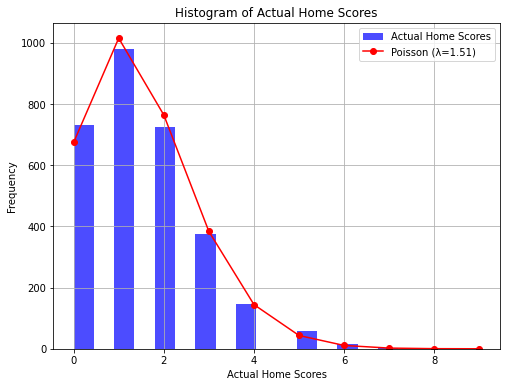

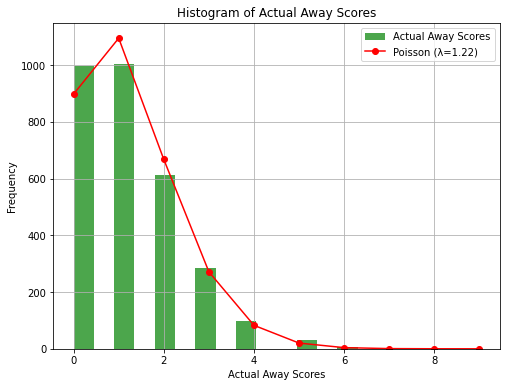

In [16]:
from scipy.stats import poisson

# Plot histogram for actual home scores
plt.figure(figsize=(8, 6))
plt.hist(train['home_score'], bins=20, color='blue', alpha=0.7, label='Actual Home Scores', density=False)
plt.xlabel('Actual Home Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Home Scores')

# Calculate mean for home scores
mean_home_score = np.mean(train['home_score'])

# Generate Poisson distribution for home scores
x_home = np.arange(0, 10)
poisson_home = poisson.pmf(x_home, mean_home_score) * len(train['home_score'])
plt.plot(x_home, poisson_home, '-o', color='red', label='Poisson (λ={:.2f})'.format(mean_home_score))

plt.legend()
plt.grid(True)
plt.show()

# Plot histogram for actual away scores
plt.figure(figsize=(8, 6))
plt.hist(train['away_score'], bins=20, color='green', alpha=0.7, label='Actual Away Scores', density=False)
plt.xlabel('Actual Away Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Away Scores')

# Calculate mean for away scores
mean_away_score = np.mean(train['away_score'])

# Generate Poisson distribution for away scores
x_away = np.arange(0, 10)
poisson_away = poisson.pmf(x_away, mean_away_score) * len(train['away_score'])
plt.plot(x_away, poisson_away, '-o', color='red', label='Poisson (λ={:.2f})'.format(mean_away_score))

plt.legend()
plt.grid(True)
plt.show()

In [17]:
train['label'] = 1
test['label'] = 1

train['GD'] = train['home_score'] - train['away_score']
test['GD'] = test['home_score'] - test['away_score']
#try later with both poisson and different regressions
ytrain_home = train['home_score']
ytrain_away = train['away_score']

ytest_home = test['home_score']
ytest_away = test['away_score']
# Dropping the columns


train.drop(['home_score', 'away_score'], axis=1, inplace=True)
test.drop(['home_score', 'away_score'], axis=1, inplace=True)


train.loc[train['GD'] > 0, 'label'] = 2
test.loc[test['GD'] > 0, 'label'] = 2


train.loc[train['GD'] < 0, 'label'] = 0

test.loc[test['GD'] < 0, 'label'] = 0


# Saving the gd as y_reg (y regression)

y_train_reg = train['GD']
y_test_reg = test['GD']

y_train = train['label']
y_test = test['label']




train.drop(['GD', 'label'], axis=1, inplace=True)
test.drop(['GD', 'label'], axis=1, inplace=True)


In [18]:
def get_versus(df, attributes, statistics):
    versus_df = pd.DataFrame()
    for att in attributes:
        for stat in statistics:
            versus_df[att+'_'+att+"__"+stat] = df['HomePlayer_'+att+'_'+stat] - df['AwayPlayer_'+att+'_'+stat]
    return versus_df

In [19]:
train.dropna(axis=0).shape

(3040, 113)

In [20]:
train.shape

(3040, 113)

In [21]:
train.head()

,home_team_name_AFC Bournemouth,home_team_name_Arsenal,home_team_name_Aston Villa,home_team_name_Brentford,home_team_name_Brighton & Hove Albion,home_team_name_Burnley,home_team_name_Cardiff City,home_team_name_Chelsea,home_team_name_Crystal Palace,home_team_name_Everton,home_team_name_Fulham,home_team_name_Huddersfield Town,home_team_name_Hull City,home_team_name_Leeds United,home_team_name_Leicester City,home_team_name_Liverpool,home_team_name_Manchester City,home_team_name_Manchester United,home_team_name_Middlesbrough,home_team_name_Newcastle United,home_team_name_Norwich City,home_team_name_Queens Park Rangers,home_team_name_Sheffield United,home_team_name_Southampton,home_team_name_Stoke City,home_team_name_Sunderland,home_team_name_Swansea City,home_team_name_Tottenham Hotspur,home_team_name_Watford,home_team_name_West Bromwich Albion,home_team_name_West Ham United,home_team_name_Wolverhampton Wanderers,away_team_name_AFC Bournemouth,away_team_name_Arsenal,away_team_name_Aston Villa,away_team_name_Brentford,away_team_name_Brighton & Hove Albion,away_team_name_Burnley,away_team_name_Cardiff City,away_team_name_Chelsea,away_team_name_Crystal Palace,away_team_name_Everton,away_team_name_Fulham,away_team_name_Huddersfield Town,away_team_name_Hull City,away_team_name_Leeds United,away_team_name_Leicester City,away_team_name_Liverpool,away_team_name_Manchester City,away_team_name_Manchester United,away_team_name_Middlesbrough,away_team_name_Newcastle United,away_team_name_Norwich City,away_team_name_Queens Park Rangers,away_team_name_Sheffield United,away_team_name_Southampton,away_team_name_Stoke City,away_team_name_Sunderland,away_team_name_Swansea City,away_team_name_Tottenham Hotspur,away_team_name_Watford,away_team_name_West Bromwich Albion,away_team_name_West Ham United,away_team_name_Wolverhampton Wanderers,HomePlayer_Overall_max,HomePlayer_Overall_min,HomePlayer_Overall_sd,HomePlayer_Overall_mean,HomePlayer_Overall_mean_ln,HomePlayer_Overall_mean_sqrt,HomePlayer_3rd_best,HomePlayer_3rd_worst,AwayPlayer_Overall_max,AwayPlayer_Overall_min,AwayPlayer_Overall_sd,AwayPlayer_Overall_mean,AwayPlayer_Overall_mean_ln,AwayPlayer_Overall_mean_sqrt,AwayPlayer_3rd_best,AwayPlayer_3rd_worst,HomePlayer_Age_mean,AwayPlayer_Age_mean,HomePlayer_Height_mean,AwayPlayer_Height_mean,HomePlayer_Weight_mean,AwayPlayer_Weight_mean,home_GD_prior,home_Points_prior,home_GD_form,home_Points_form,home_GD_form_pw,home_Points_form_pw,away_GD_prior,away_Points_prior,away_GD_form,away_GD_form_pw,away_Points_form_pw,away_Points_form,Matchweek,home_points_to_championship,home_points_to_ucl,home_points_to_rel,away_points_to_championship,away_points_to_ucl,away_points_to_rel,home_match_importance,away_match_importance,B365A,B365D,B365H,HtA,Home_min_max,Away_min_max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86,66,7.785768,78.272727,4.355475,8.836876,86,69,74,69,1.513575,71.909091,4.275201,8.479495,73,71,25.545455,26.454545,181.545455,182.090909,76.181818,78.000000,12.0,63.0,0.0,10.0,0.000000,1.428571,-20.0,42.0,-4.0,-0.571429,0.571429,4.0,38,17.0,2.0,-25.0,38.0,23.0,-4.0,2.0,0.0,5.25,4.20,1.67,1.0,5676,5106
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87,74,4.006812,81.636364,4.401164,9.032785,85,78,77,62,4.261882,73.818182,4.299952,8.588280,76,73,26.545455,24.909091,180.545455,179.727273,74.272727,75.000000,25.0,68.0,3.0,10.0,0.428571,1.428571,-45.0,17.0,-5.0,-0.714286,0.142857,1.0,38,12.0,-3.0,-30.0,63.0,48.0,21.0,-3.0,0.0,17.00,9.00,1.17,1.0,6438,4774
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [22]:
to_log = ['Overall', 'Height', 'Weight']
'''
for col in train.columns:
    for t in to_log:
        if t in col:
            train[col] = np.log2(train[col])
            test[col] = np.log2(test[col])
'''
#versus_train = get_versus(train, to_log, ['mean','min','max','sd'])
#versus_test = get_versus(test, to_log, ['mean','min','max','sd'])


'\nfor col in train.columns:\n    for t in to_log:\n        if t in col:\n            train[col] = np.log2(train[col])\n            test[col] = np.log2(test[col])\n'

In [23]:
for col in train.columns:
    if col not in test.columns:
        print(col)
        print(test.columns)

In [24]:
train.to_csv('X_train.csv')
y_train.to_csv("Y_train.csv")
test.to_csv('X_test.csv')
y_test.to_csv("Y_test.csv")


In [25]:

# Standardize the data for numeric columns
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns)

test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns)


Text(0, 0.5, 'Density')

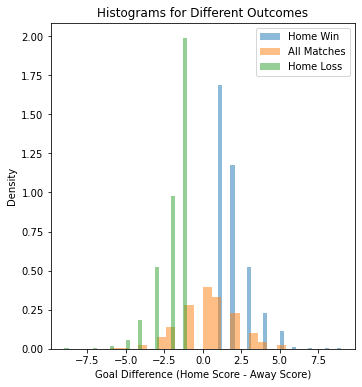

In [26]:

# Separate the data based on labels
home_win_data = y_train_reg[y_train == 2]
home_loss = y_train_reg[y_train == 0]

# Create histograms
plt.figure(figsize=(12, 6))

# Plot histograms
plt.subplot(1, 2, 1)
plt.hist(home_win_data, bins=30, alpha=0.5, label='Home Win', density=True)
plt.hist(y_train_reg, bins=30, alpha=0.5, label='All Matches', density=True)
plt.hist(home_loss, bins=30, alpha=0.5, label='Home Loss', density=True)
plt.legend()
plt.title('Histograms for Different Outcomes')
plt.xlabel('Goal Difference (Home Score - Away Score)')
plt.ylabel('Density')



In [65]:

from scipy.stats import norm, skellam


def bet_and_plot_thresh(predict_proba_output, labels, earning_matrix, earning_odds, initial_dollar=1, extra_title='', threshold=0):
    # Find the index of the maximum predicted probability for each data point
    predicted_labels = np.argmax(predict_proba_output, axis=1)
    predicted_bo = np.argmax(earning_odds, axis=1)
    
    # Initialize earnings
    earnings = []
    bo_earnings = []
    
    # Iterate through each data point for regular betting
    for i in range(len(predicted_labels)):
        if predicted_labels[i] > threshold:
            if predicted_labels[i] == labels[i]:
                earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
            else:
                earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
        else:
            earnings.append(0)
    
    # Iterate through each data point for betting odds
    for i in range(len(predicted_bo)):
    # Check if the match is worth betting
        if predicted_bo[i] == labels[i]:
            bo_earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
        else:
            bo_earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing


    # Calculate total earnings
    total_earnings = initial_dollar + np.sum(earnings)
    total_bo_earnings = initial_dollar + np.sum(bo_earnings)
    
    # Calculate the delta between earnings
    delta_earnings = np.array(earnings) - np.array(bo_earnings)
    
    # Plot earnings for regular betting
    plt.plot(np.cumsum(earnings) + initial_dollar, label='Total Earnings (Using ML)', color='blue')
    
    # Plot earnings for betting odds
    plt.plot(np.cumsum(bo_earnings) + initial_dollar, label='Total Earnings (Betting Odds)', color='green')
    
    # Plot delta earnings
    plt.plot(np.cumsum(delta_earnings) + initial_dollar, label='Delta Earnings', color='red', linestyle='--')
    
    plt.xlabel('Number of Bets')
    plt.ylabel('Earnings ($)')
    plt.title('Earnings Over Bets' + extra_title)
    plt.legend()
    plt.show()
    
    print("Total earnings after all bets (Using the model):", total_earnings)
    print("Total earnings after all bets (Betting Odds):", total_bo_earnings)

def bet_and_plot(predict_proba_output, labels, earning_matrix, earning_odds, initial_dollar=1, extra_title = ''):
    # Find the index of the maximum predicted probability for each data point
    predicted_labels = np.argmax(predict_proba_output, axis=1)
    predicted_bo = np.argmax(earning_odds, axis=1)
    
    # Initialize earnings
    earnings = []
    bo_earnings = []
    
    # Iterate through each data point for regular betting
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == labels[i]:
            earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
        else:
            earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
    
    # Iterate through each data point for betting odds
    for i in range(len(predicted_bo)):
        if predicted_bo[i] == labels[i]:
            bo_earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
        else:
            bo_earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
            
    # Calculate total earnings
    total_earnings = initial_dollar + np.sum(earnings)
    total_bo_earnings = initial_dollar + np.sum(bo_earnings)
    
    # Calculate the delta between earnings
    delta_earnings = np.array(earnings) - np.array(bo_earnings)
    
    # Plot earnings for regular betting
    plt.plot(np.cumsum(earnings) + initial_dollar, label='Total Earnings (Using ML)', color='blue')
    
    # Plot earnings for betting odds
    plt.plot(np.cumsum(bo_earnings) + initial_dollar, label='Total Earnings (Betting Odds)', color='green')
    
    # Plot delta earnings
    plt.plot(np.cumsum(delta_earnings) + initial_dollar, label='Delta Earnings', color='red', linestyle='--')
    
    plt.xlabel('Number of Bets')
    plt.ylabel('Earnings ($)')
    plt.title('Earnings Over Bets' + extra_title)
    plt.legend()
    plt.show()
    
    print("Total earnings after all bets (Using the model):", total_earnings)
    print("Total earnings after all bets (Betting Odds):", total_bo_earnings)


def extract_poisson_probas_binary(home_pred, away_pred):
    '''
    creates a probability matrix according to the regression

    Parameters:
    home_pred: expected home score
    away_pred: expected away score
    '''

    probability_matrix = np.zeros((len(home_pred), 3))  # 3 columns (-1, 0, 1 probabilities)
    
    for i in range(len(home_pred)):
        # Check for NaN values and skip the calculation if found
        if np.isnan(home_pred[i]) or np.isnan(away_pred[i]):
            continue

        home_rounded = home_pred[i]
        away_rounded = away_pred[i]
                
        probability_matrix[i, 0] = skellam.cdf(-1, home_rounded, away_rounded, loc=np.mean(home_pred) - np.mean(away_pred))
        probability_matrix[i, 1] = skellam.sf(-1, home_rounded, away_rounded, loc=np.mean(home_pred) - np.mean(away_pred))
        if(probability_matrix[i, 0] == np.nan or probability_matrix[i, 1] == np.nan or probability_matrix[i, 2] == np.nan):
            print("NAN PRODUCED IN INDEX", i)
        
    return probability_matrix

def extract_poisson_probas(home_pred, away_pred):
    '''
    creates a probability matrix according to the regression

    Parameters:
    home_pred: expected home score
    away_pred: expected away score
    '''

    probability_matrix = np.zeros((len(home_pred), 3))  # 3 columns (-1, 0, 1 probabilities)
    
    for i in range(len(home_pred)):
        # Check for NaN values and skip the calculation if found
        if np.isnan(home_pred[i]) or np.isnan(away_pred[i]):
            continue

        home_rounded = home_pred[i]
        away_rounded = away_pred[i]
                
        probability_matrix[i, 0] = skellam.cdf(-1, home_rounded, away_rounded)
        probability_matrix[i, 1] = skellam.pmf(0, home_rounded, away_rounded)
        probability_matrix[i, 2] = skellam.sf(0, home_rounded, away_rounded)
        if(probability_matrix[i, 0] == np.nan or probability_matrix[i, 1] == np.nan or probability_matrix[i, 2] == np.nan):
            print("NAN PRODUCED IN INDEX", i)
        
    return probability_matrix


    
def extract_probas(pred, sd, upper_threshold, lower_threshold):
    '''
    creates a probability matrix according to the regression

    Parameters:
    pred: the prediction from the regression
    sd: Standard Deviation for the variable
    bias: Here will be the mean of the goal differences (takes into account home advantage)
    '''

    
    probability_matrix = np.zeros((len(pred), 3)) # 3 columns (-1, 0, 1 probabilities)
    for i in range(len(pred)):
        probability_matrix[i, 0] = norm.cdf(lower_threshold, loc=pred[i], scale=sd)
        probability_matrix[i, 1] = norm.cdf(upper_threshold, loc=pred[i], scale=sd) - probability_matrix[i, 0]
        probability_matrix[i, 2] = 1 - probability_matrix[i, 1] - probability_matrix[i, 0]
        
    return probability_matrix


def bet_and_plot_harsh(predict_proba_output, labels, earning_matrix, earning_odds, initial_dollar=1):
    # Find the index of the maximum predicted probability for each data point
    predicted_labels = np.argmax(predict_proba_output, axis=1)
    predicted_bo = np.argmax(earning_odds, axis=1)
    
    # Initialize earnings
    earnings = []
    bo_earnings = []
    
    # Iterate through each data point for regular betting
    for i in range(len(predicted_labels)):
        pred = 1
        if predict_proba_output[i, predicted_labels[i]] > 0.5:
            pred = predicted_labels[i]
        if pred == labels[i]:
            earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
        else:
            earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
    
    # Iterate through each data point for betting odds
    for i in range(len(predicted_bo)):
        if predicted_bo[i] == labels[i]:
            bo_earnings.append(initial_dollar * (earning_matrix.iloc[i, labels[i]] - 1))
        else:
            bo_earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
            
    # Calculate total earnings
    total_earnings = initial_dollar + np.sum(earnings)
    total_bo_earnings = initial_dollar + np.sum(bo_earnings)
    
    # Calculate the delta between earnings
    delta_earnings = np.array(earnings) - np.array(bo_earnings)
    
    # Plot earnings for regular betting
    plt.plot(np.cumsum(earnings) + initial_dollar, label='Total Earnings (Using ML)', color='blue')
    
    # Plot earnings for betting odds
    plt.plot(np.cumsum(bo_earnings) + initial_dollar, label='Total Earnings (Betting Odds)', color='green')
    
    # Plot delta earnings
    plt.plot(np.cumsum(delta_earnings) + initial_dollar, label='Delta Earnings', color='red', linestyle='--')
    
    plt.xlabel('Number of Bets')
    plt.ylabel('Earnings ($)')
    plt.title('Earnings Over Bets')
    plt.legend()
    plt.show()
    
    print("Total earnings after all bets (Using the model):", total_earnings)
    print("Total earnings after all bets (Betting Odds):", total_bo_earnings)

In [66]:
betting_data.columns = [0, 1, 2]
bo_labels = y_test
bet_sum = np.sum(betting_data, axis=1)

normalized_probas = np.array(1 / betting_data)
normalized_probas
bet_sum = np.sum(normalized_probas, axis=1).reshape(-1, 1)
normalized_probas
normalized_probas /= bet_sum

train_betting = train[['B365A', 'B365D', 'B365H']]
train_betting.columns = [0, 1, 2]
train_normalized_probas = np.array(1 / train_betting)
bet_sum = np.sum(train_normalized_probas, axis=1).reshape(-1, 1)
train_normalized_probas
train_normalized_probas /= bet_sum

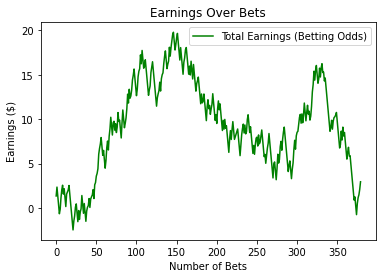

In [67]:
initial_dollar=1
predicted_bo = np.argmin(np.array(betting_data), axis=1)
bo_earnings = []

# Iterate through each data point for betting odds
for i in range(len(bo_labels)):
    if predicted_bo[i] == bo_labels[i]:
        bo_earnings.append(initial_dollar * (betting_data.at[i,predicted_bo[i]] - 1))
    else:
        bo_earnings.append(-initial_dollar)  # If the prediction is incorrect, earn nothing
total_bo_earnings = np.sum(bo_earnings)+initial_dollar
plt.plot(np.cumsum(bo_earnings) + initial_dollar, label='Total Earnings (Betting Odds)', color='green')
plt.xlabel('Number of Bets')
plt.ylabel('Earnings ($)')
plt.title('Earnings Over Bets')
plt.legend()
plt.show()

In [68]:
normalized_probas

array([[0.11896035, 0.18127291, 0.69976674],
       [0.26865672, 0.26119403, 0.47014925],
       [0.51570876, 0.23593676, 0.24835448],
       ...,
       [0.11190148, 0.17293866, 0.71515986],
       [0.58989141, 0.23743129, 0.1726773 ],
       [0.51167513, 0.26294416, 0.22538071]])

In [69]:
betting_odds_auc = roc_auc_score(bo_labels, normalized_probas, multi_class='ovr')
print(f"betting odds AUC: {betting_odds_auc}")

betting odds AUC: 0.6666565905809213


In [70]:
normalized_probas = np.array(normalized_probas)

In [71]:
normalized_probas

array([[0.11896035, 0.18127291, 0.69976674],
       [0.26865672, 0.26119403, 0.47014925],
       [0.51570876, 0.23593676, 0.24835448],
       ...,
       [0.11190148, 0.17293866, 0.71515986],
       [0.58989141, 0.23743129, 0.1726773 ],
       [0.51167513, 0.26294416, 0.22538071]])

In [72]:
bo_classes = np.argmax(normalized_probas, axis=1)

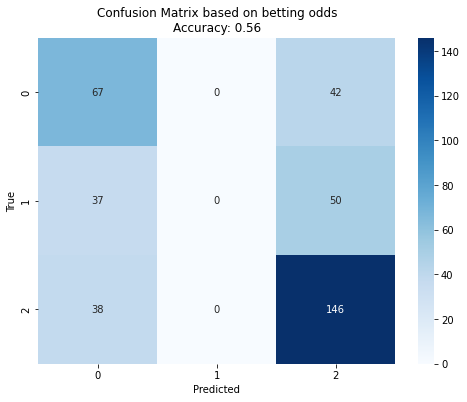

In [73]:
# Create a confusion matrix

conf_matrix = confusion_matrix(bo_labels, bo_classes)

# Calculate accuracy
accuracy = accuracy_score(bo_labels, bo_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix based on betting odds\nAccuracy: {accuracy:.2f}')
plt.show()



Different way to model:
We can model the expected GD, and using that, we take the another model (svm or knn) to predict the outcome

In [74]:
X_train = train.copy()
X_test = test.copy()
# X_train.drop([ 'away_Points_form_pw',
#                  'home_points_to_championship',
#                 'home_points_to_ucl','home_points_to_rel','away_points_to_championship',
#              
#               'HomePlayer_Overall_mean_ln', 'AwayPlayer_Overall_mean_ln',
#               'Home_min_max','Away_min_max', 'capacity',
#               'AwayPlayer_Overall_min', 'HomePlayer_Overall_min'], inplace=True, axis=1)
# X_test.drop([ 'away_Points_form_pw',
#                  'home_points_to_championship',
#                 'home_points_to_ucl','home_points_to_rel','away_points_to_championship',
#                 'away_points_to_ucl',
#              'HomePlayer_Overall_mean_ln', 'AwayPlayer_Overall_mean_ln',  'Home_min_max','Away_min_max',
#               'AwayPlayer_Overall_min', 'HomePlayer_Overall_min','capacity',
#               ],inplace=True, axis=1)


In [75]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(train_scaled, columns=X_train.columns)

test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(test_scaled, columns=X_train.columns)




In [76]:
print('home scoring avg:', ytrain_home.mean(),'\nwith an sd of:', ytrain_home.std())
print('away scoring avg:', ytrain_away.mean(),'\nwith an sd of:', ytrain_away.std())

home scoring avg: 1.5055921052631578 
with an sd of: 1.2979728207120609
away scoring avg: 1.219407894736842 
with an sd of: 1.1923656094908108


In [77]:
from sklearn.ensemble import RandomForestRegressor

home_reg = GridSearchCV(RandomForestRegressor(n_estimators=500),
                        param_grid={'max_features' : [.3, .35],
                                    'max_depth' : [5],
                                    'max_samples' : [.12, 0.15],
                                    'criterion' : ['poisson']},
                        scoring='neg_mean_absolute_error', cv=3, verbose=3)

away_reg =GridSearchCV(RandomForestRegressor(n_estimators=500),
                        param_grid={'max_features' : [.3, .35],
                                    'max_depth' : [5],
                                    'max_samples' : [.12, 0.15],
                                    'criterion' : ['poisson']},
                        scoring='neg_mean_absolute_error', cv=3, verbose=3)


home_reg.fit(train, ytrain_home)
away_reg.fit(train, ytrain_away)


print("best hyper parameters for home regression:", home_reg.best_params_)
print("best parameters for away reg:", away_reg.best_params_)
home_train = home_reg.predict(train)
away_train = away_reg.predict(train)

home_test = home_reg.predict(test)
away_test = away_reg.predict(test)
print('train home rmse:', np.sqrt(mean_squared_error(ytrain_home, home_train)))
print('train away rmse:', np.sqrt(mean_squared_error(ytrain_away, away_train)))

print('test home rmse:', np.sqrt(mean_squared_error(ytest_home, home_test)))
print('test away rmse:', np.sqrt(mean_squared_error(ytest_away, away_test)))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END criterion=poisson, max_depth=5, max_features=0.3, max_samples=0.12;, score=-0.940 total time=   1.8s
[CV 2/3] END criterion=poisson, max_depth=5, max_features=0.3, max_samples=0.12;, score=-0.958 total time=   1.9s
[CV 3/3] END criterion=poisson, max_depth=5, max_features=0.3, max_samples=0.12;, score=-0.924 total time=   1.7s
[CV 1/3] END criterion=poisson, max_depth=5, max_features=0.3, max_samples=0.15;, score=-0.939 total time=   1.9s
[CV 2/3] END criterion=poisson, max_depth=5, max_features=0.3, max_samples=0.15;, score=-0.959 total time=   1.7s
[CV 3/3] END criterion=poisson, max_depth=5, max_features=0.3, max_samples=0.15;, score=-0.925 total time=   1.5s
[CV 1/3] END criterion=poisson, max_depth=5, max_features=0.35, max_samples=0.12;, score=-0.938 total time=   1.5s
[CV 2/3] END criterion=poisson, max_depth=5, max_features=0.35, max_samples=0.12;, score=-0.960 total time=   1.5s
[CV 3/3] END criterion=poi

KeyboardInterrupt: 

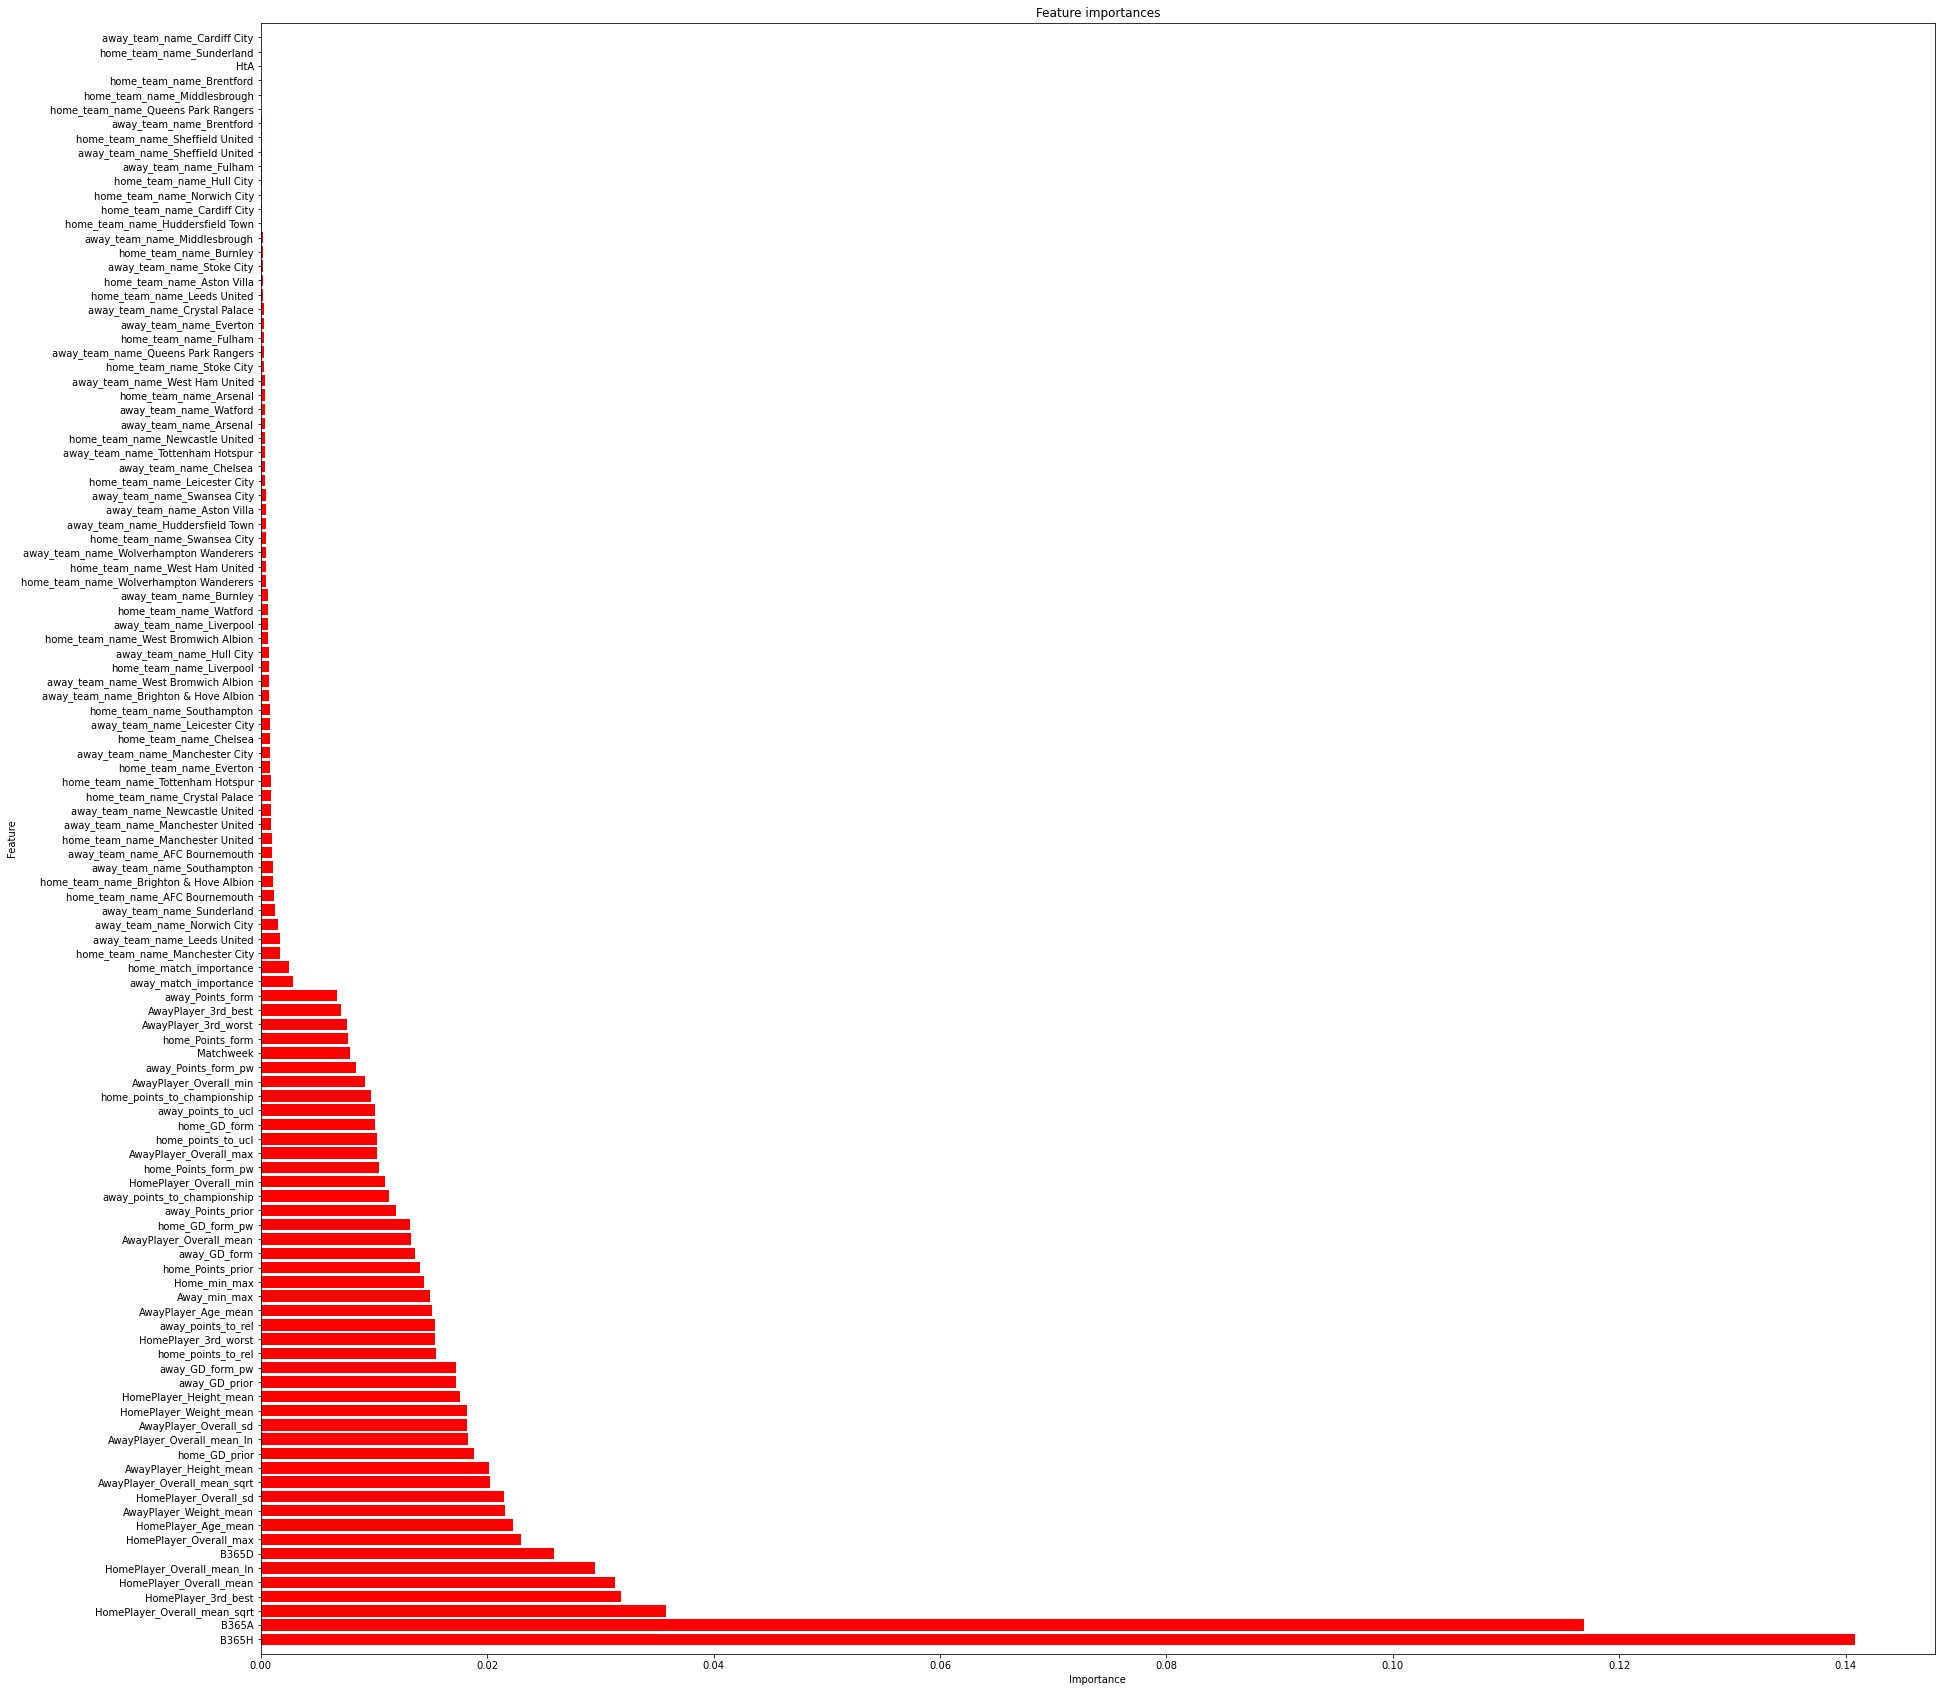

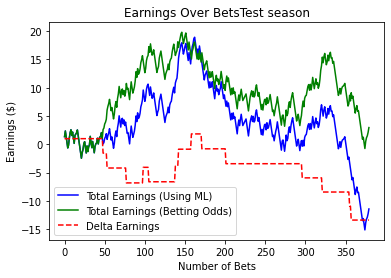

Total earnings after all bets (Using the model): -11.41
Total earnings after all bets (Betting Odds): 2.960000000000001


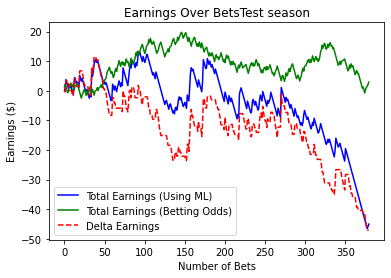

Total earnings after all bets (Using the model): -45.04
Total earnings after all bets (Betting Odds): 2.960000000000001


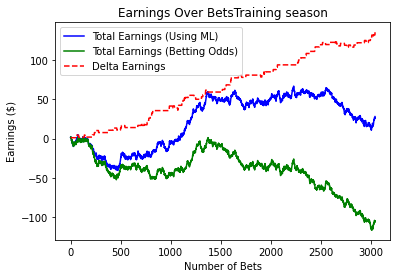

Total earnings after all bets (Using the model): 27.840000000000025
Total earnings after all bets (Betting Odds): -106.26999999999998


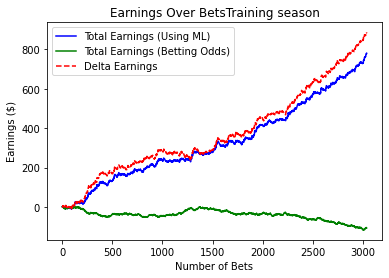

Total earnings after all bets (Using the model): 779.82
Total earnings after all bets (Betting Odds): -106.26999999999998


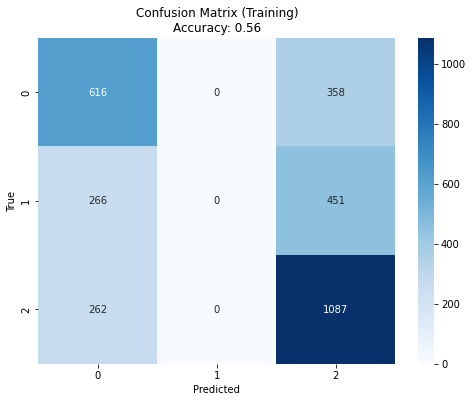

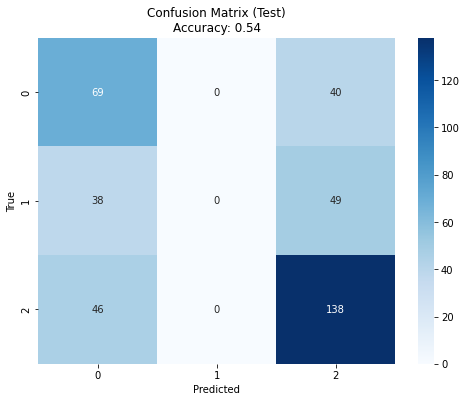

Training OvR AUC: 0.7131953120752766
Test OvR AUC: 0.6566759805077251


"\nbest hyper parameters for home regression: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3333333333333333, 'max_samples': 0.15}\nbest parameters for away reg: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3333333333333333, 'max_samples': 0.2}\n"

In [ ]:

# Get feature importances
importances = home_reg.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = train.columns[indices]

# Plot the feature importances
plt.figure(figsize=(30,30))
plt.title("Feature importances")
plt.barh(range(train.shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(train.shape[1]), feature_names)
plt.ylim([-1, train.shape[1]])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
train_probas = extract_poisson_probas(home_train, away_train)
test_probas = extract_poisson_probas(home_test, away_test)
bet_and_plot(test_probas, y_test, betting_data, normalized_probas, extra_title='Test season')
bet_and_plot(np.asarray(test_probas-normalized_probas), y_test, betting_data, normalized_probas, extra_title='Test season')

bet_and_plot(train_probas, y_train, train_betting, train_normalized_probas, extra_title='Training season')
bet_and_plot(np.asarray(train_probas-train_normalized_probas), y_train, train_betting, train_normalized_probas, extra_title='Training season')
train_classes = np.argmax(train_probas, axis=1)
train_classes = train_classes

# Create a confusion matrix
conf_matrix = confusion_matrix(y_train, train_classes)

# Calculate accuracy
accuracy = accuracy_score(y_train, train_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Training)\nAccuracy: {accuracy:.2f}')
plt.show()

test_classes = np.argmax(test_probas, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, test_classes)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Test)\nAccuracy: {accuracy:.2f}')
plt.show()
train_auc_ovr = roc_auc_score(y_train, train_probas, multi_class='ovr')
print(f"Training OvR AUC: {train_auc_ovr}")

# Calculate OvO AUC for the test set
test_auc_ovr = roc_auc_score(y_test, test_probas, multi_class='ovr')
print(f"Test OvR AUC: {test_auc_ovr}")
'''
best hyper parameters for home regression: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3333333333333333, 'max_samples': 0.15}
best parameters for away reg: {'criterion': 'poisson', 'max_depth': 5, 'max_features': 0.3333333333333333, 'max_samples': 0.2}
'''

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END max_depth=1, n_estimators=50, objective=count:poisson, subsample=0.15;, score=-0.939 total time=   0.0s
[CV 2/3] END max_depth=1, n_estimators=50, objective=count:poisson, subsample=0.15;, score=-0.986 total time=   0.0s
[CV 3/3] END max_depth=1, n_estimators=50, objective=count:poisson, subsample=0.15;, score=-0.922 total time=   0.0s
[CV 1/3] END max_depth=1, n_estimators=50, objective=count:poisson, subsample=0.5;, score=-0.943 total time=   0.0s
[CV 2/3] END max_depth=1, n_estimators=50, objective=count:poisson, subsample=0.5;, score=-0.960 total time=   0.0s
[CV 3/3] END max_depth=1, n_estimators=50, objective=count:poisson, subsample=0.5;, score=-0.928 total time=   0.0s
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END max_depth=1, n_estimators=10, objective=count:poisson, subsample=0.15;, score=-0.897 total time=   0.0s
[CV 2/3] END max_depth=1, n_estimators=10, objective=count:poiss

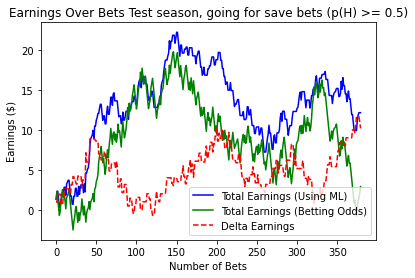

Total earnings after all bets (Using the model): 12.18
Total earnings after all bets (Betting Odds): 2.960000000000001


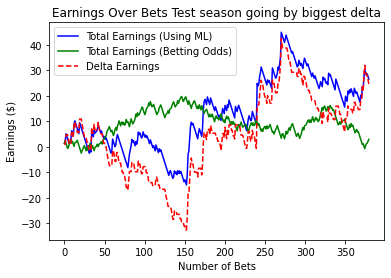

Total earnings after all bets (Using the model): 26.619999999999997
Total earnings after all bets (Betting Odds): 2.960000000000001


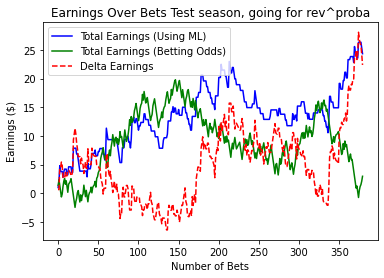

Total earnings after all bets (Using the model): 24.33
Total earnings after all bets (Betting Odds): 2.960000000000001


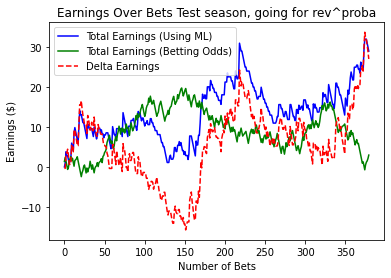

Total earnings after all bets (Using the model): 29.03
Total earnings after all bets (Betting Odds): 2.960000000000001


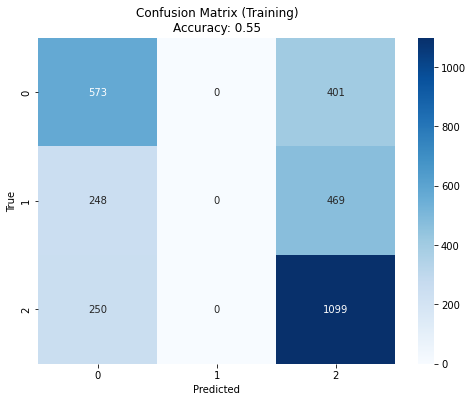

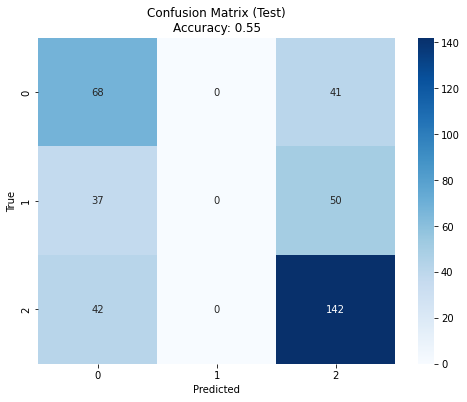

Training OvR AUC: 0.6921480225965256
Test OvR AUC: 0.6712773088862338


"\nbest hyper parameters for home regression: {'max_depth': 1, 'n_estimators': 100, 'objective': 'count:poisson', 'subsample': 0.5}\nbest parameters for away reg: {'max_depth': 1, 'n_estimators': 50, 'objective': 'count:poisson', 'subsample': 0.5}\n"

In [78]:
from xgboost import XGBRegressor

home_reg = GridSearchCV(XGBRegressor(eval_metric ='poisson-nloglik'),
                        param_grid={'n_estimators' : list(range(50, 100, 50)),
                                    'max_depth' : [1],
                                    'subsample' : [0.15, .5],
                                    'objective' : ['count:poisson']},
                        scoring='neg_mean_absolute_error', cv=3, verbose=3)

away_reg =GridSearchCV(XGBRegressor(eval_metric ='poisson-nloglik'),
                        param_grid={'n_estimators' : list(range(10, 100, 10)),
                                    'max_depth' : [1],
                                    'subsample' : [0.15, .5],
                                    'objective' : ['count:poisson']},
                        scoring='neg_mean_absolute_error', cv=3, verbose=3)



home_reg.fit(train, ytrain_home)
away_reg.fit(train, ytrain_away)


print("best hyper parameters for home regression:", home_reg.best_params_)
print("best parameters for away reg:", away_reg.best_params_)

home_train = home_reg.predict(train)
away_train = away_reg.predict(train)

home_test = home_reg.predict(test)
away_test = away_reg.predict(test)

print('train home rmse:', np.sqrt(mean_squared_error(ytrain_home, home_train)))
print('train away rmse:', np.sqrt(mean_squared_error(ytrain_away, away_train)))

print('test home rmse:', np.sqrt(mean_squared_error(ytest_home, home_test)))
print('test away rmse:', np.sqrt(mean_squared_error(ytest_away, away_test)))

train_probas = extract_poisson_probas(home_train, away_train)
test_probas = extract_poisson_probas(home_test, away_test)
bet_and_plot_thresh(test_probas, y_test, betting_data, normalized_probas, extra_title=' Test season, going for save bets (p(H) >= 0.5)')
bet_and_plot(np.asarray(test_probas-normalized_probas), y_test, betting_data, normalized_probas, extra_title=' Test season going by biggest delta')
bet_and_plot_thresh(np.power(np.asarray(betting_data),test_probas), y_test, betting_data, normalized_probas, extra_title=' Test season, going for rev^proba', threshold=1)
bet_and_plot_thresh(test_probas*np.log(np.asarray(betting_data)), y_test, betting_data, normalized_probas, extra_title=' Test season, going for rev^proba')


train_classes = np.argmax(train_probas, axis=1)
train_classes = train_classes

# Create a confusion matrix
conf_matrix = confusion_matrix(y_train, train_classes)

# Calculate accuracy
accuracy = accuracy_score(y_train, train_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Training)\nAccuracy: {accuracy:.2f}')
plt.show()

test_classes = np.argmax(test_probas, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, test_classes)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Test)\nAccuracy: {accuracy:.2f}')
plt.show()
train_auc_ovr = roc_auc_score(y_train, train_probas, multi_class='ovr')
print(f"Training OvR AUC: {train_auc_ovr}")

# Calculate OvO AUC for the test set
test_auc_ovr = roc_auc_score(y_test, test_probas, multi_class='ovr')
print(f"Test OvR AUC: {test_auc_ovr}")
'''
best hyper parameters for home regression: {'max_depth': 1, 'n_estimators': 100, 'objective': 'count:poisson', 'subsample': 0.5}
best parameters for away reg: {'max_depth': 1, 'n_estimators': 50, 'objective': 'count:poisson', 'subsample': 0.5}
'''

In [ ]:
# # ## Save the model

# home_reg.best_estimator_.save_model("home_regression.json")
# away_reg.best_estimator_.save_model("away_regression.json")

2 regressions: 
1. regression for shots (in general) 
2. scoring rate
